<a href="https://colab.research.google.com/github/Benj-admin/MAP583_X/blob/main/TP/TP03_optimization_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization algorithms

Code adapted from the [optimization chapter](http://www.d2l.ai/chapter_optimization/) of Dive into Deep Learning. The objectives are:

1.   To show the advantages and disadvantages of several popular optimization algorithms on simple 2d functions.
2.   To explore the impact of gradient noise and mini-batch size on the training of simple models.


We will thus fix the function to learn, and try several optimization algorithms on it. The following functions are used to access the gradient (`get_gradient`), run an optimization loop with a given update rule (`optimize`), and show the trace of this optimization loop on a figure (`show_trace_2d`). `show_trace_2d` requires as inputs: the function to optimize and the output of the `optimize` function. The `update` rule performs one iteration of the optimization algorithm, and will use internally `get_gradient` to access and use the gradient.

In [94]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt


def get_gradient(f, x, noise_std=0):
    """Returns the gradient of a function f at x with additive Gaussian noise."""
    x = x.detach() # Removes information about the gradient
    x.requires_grad = True
    output = f(x)
    output.backward()
    gradient = x.grad
    noise = torch.randn(gradient.shape)
    return gradient + noise_std * noise

def optimize(update, num_iter=20, init_s=0):
    """Optimize the objective function of 2d variables with a customized update."""
    """update(x,s_x) should return the updated positions x and possible memory terms."""
    x = torch.Tensor([-5, -2])
    s = init_s
    all_x = [x]
    for i in range(num_iter):
        x, s = update(x, s)
        all_x.append((x))
    print('epoch %d, x1 %f, x2 %f' % (i+1, x[0], x[1]))
    return torch.stack(all_x, dim=0)

def show_trace_2d(f, all_x, color='red', is_new_plot=True):
    """Show the trace of 2d variables during optimization."""
    # Plot the iterates x_t
    if is_new_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig = plt.gcf()
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    ax1.plot(all_x[:,0], all_x[:,1], '-o', color=color)
    all_f = np.array([f(torch.Tensor([x[0], x[1]])) for x in all_x])

    # Plot the function's level sets
    x1 = np.arange(-5.5, 3.5, 0.1)
    x2 = np.arange(-3.0, 2.0, 0.1)
    f_grid = np.array([[f(torch.Tensor([u, v])) for u in x1] for v in x2])
    ax1.contour(x1, x2, f_grid, colors='blue')
    ax1.set_xlim([-5.5, 3.5])
    ax1.set_ylim([-3.0, 2.0])
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')

    # Plot the function values f(x_t)
    ax2.plot(all_f, color=color)
    ax2.set_xlabel('time ($t$)')
    ax2.set_ylabel('function value ($f(x_t)$)')

Write a function `f` that returns $f(x) = 0.1 x_0^2 + 2 x_1^2$.

In [95]:
def f(x):
  return 0.1*x[0]**2 + 2*x[1]**2

## Gradient descent

Write a function `gd(x, s)` that takes as input a point `x` and (unused) memory state `s`, and performs one iteration (update rule) of gradient descent. Remember that `get_gradient(f, x)` returns the gradient of `f` at `x`. Then, test your update rule with step sizes `eta` equal to $0.4$ and $0.6$ using `show_trace_2d(f, optimize(gd))`.

epoch 20, x1 -0.943467, x2 -0.000073
epoch 20, x1 -0.387814, x2 -1673.367798


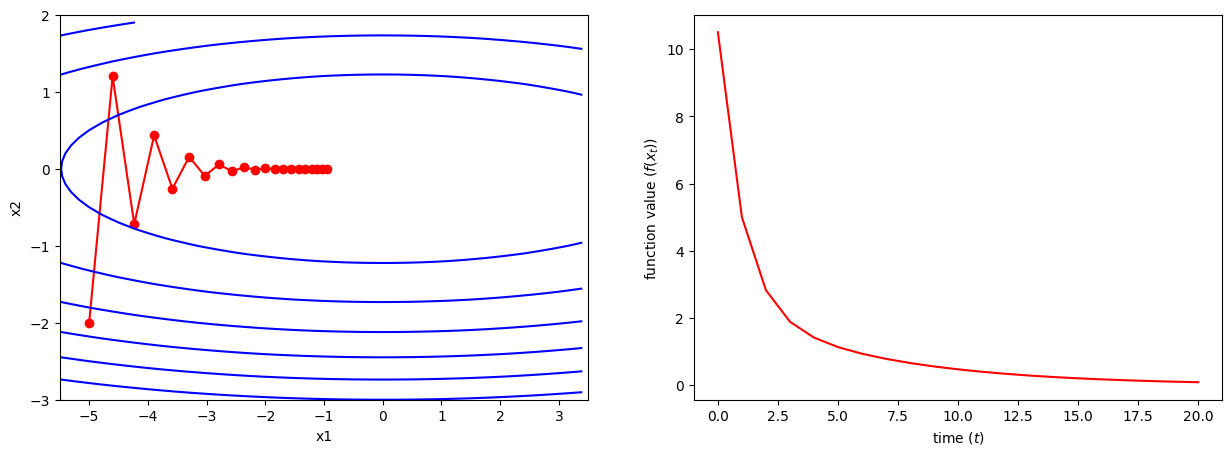

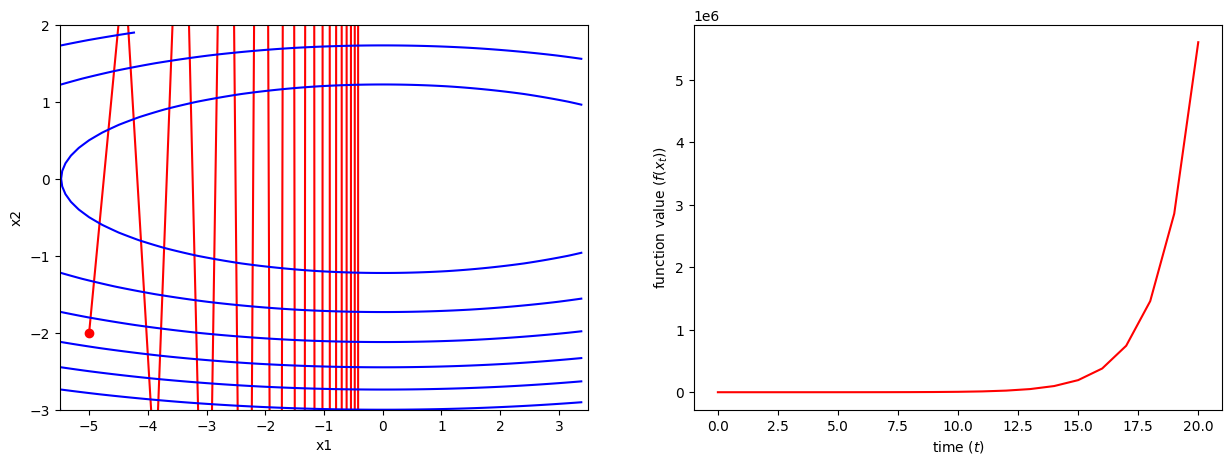

In [96]:
eta = 0.4
def gd(x, s):
    return x - eta*get_gradient(f, x), s

show_trace_2d(f, optimize(gd))
eta = 0.6
show_trace_2d(f, optimize(gd))

## Momemtum

Write a function `momentum(x, v)` that performs one iteration of the momentum method. Test your update rule on the same step-sizes as gradient descent. What happens? Try also with `eta, gamma = 0.05, 0.9`.

epoch 20, x1 -0.062843, x2 0.001202
epoch 20, x1 0.007188, x2 0.002553


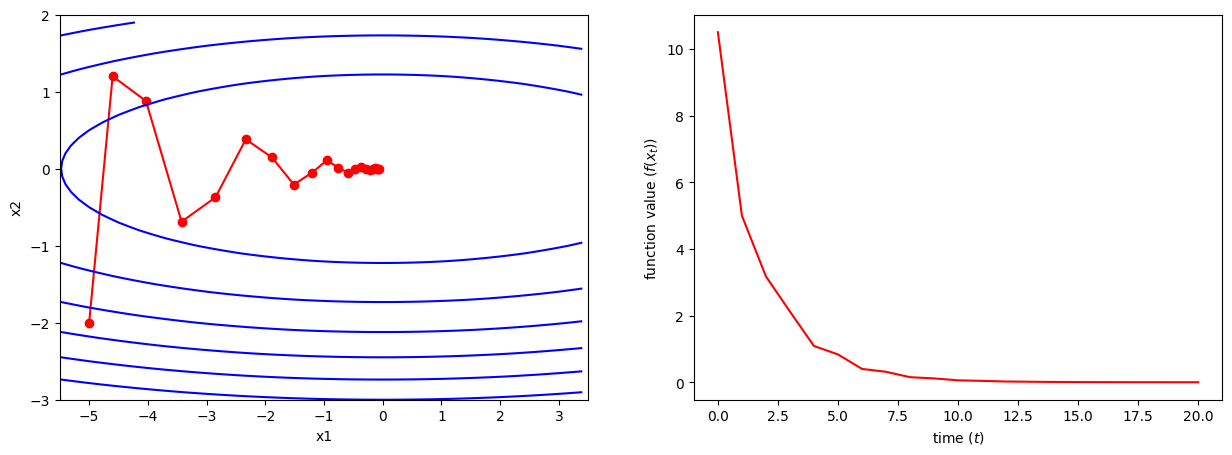

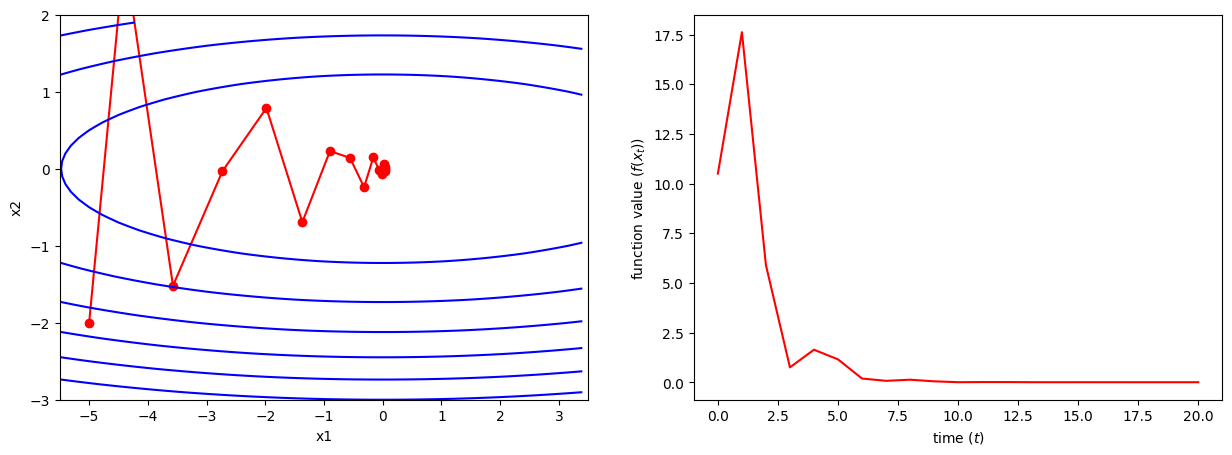

In [97]:
eta, gamma = 0.4, 0.5

def momentum(x,v):
  v = gamma*v + eta*get_gradient(f, x)
  return x - v, v

show_trace_2d(f, optimize(momentum))
eta = 0.6
show_trace_2d(f, optimize(momentum))

epoch 20, x1 -0.589111, x2 0.698505


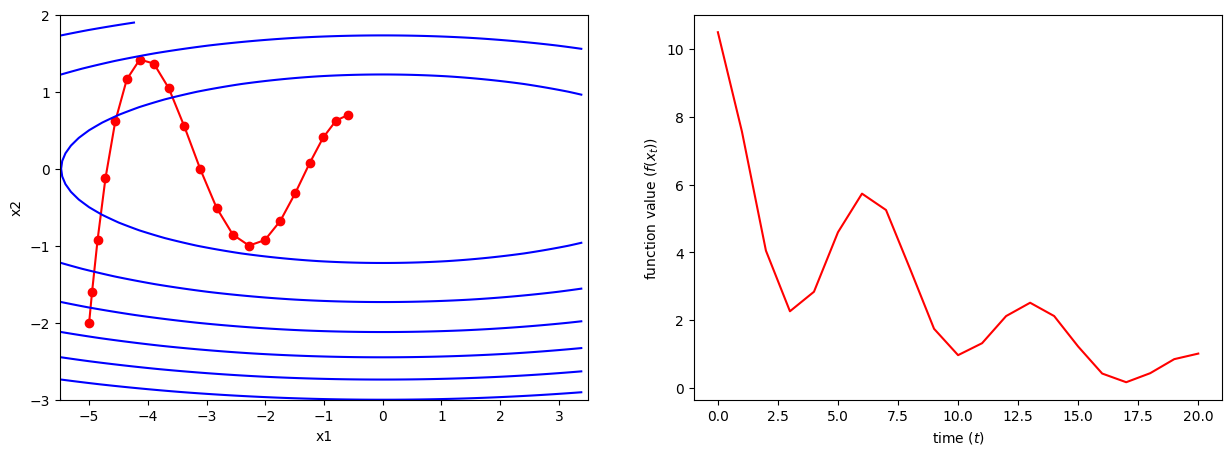

In [99]:
eta, gamma = 0.05, 0.9

show_trace_2d(f, optimize(momentum))

## Nesterov accelerated gradient

Now write the function `nesterov(x, v)` for Nesterov's accelerated grdient descent. Compare with momentum with the same hyper-parameters `eta, gamma = 0.05, 0.9`. You can use `is_new_plot=False` to show both plots on the same graph.

epoch 20, x1 -0.589111, x2 0.698505
epoch 20, x1 -0.751356, x2 0.071637


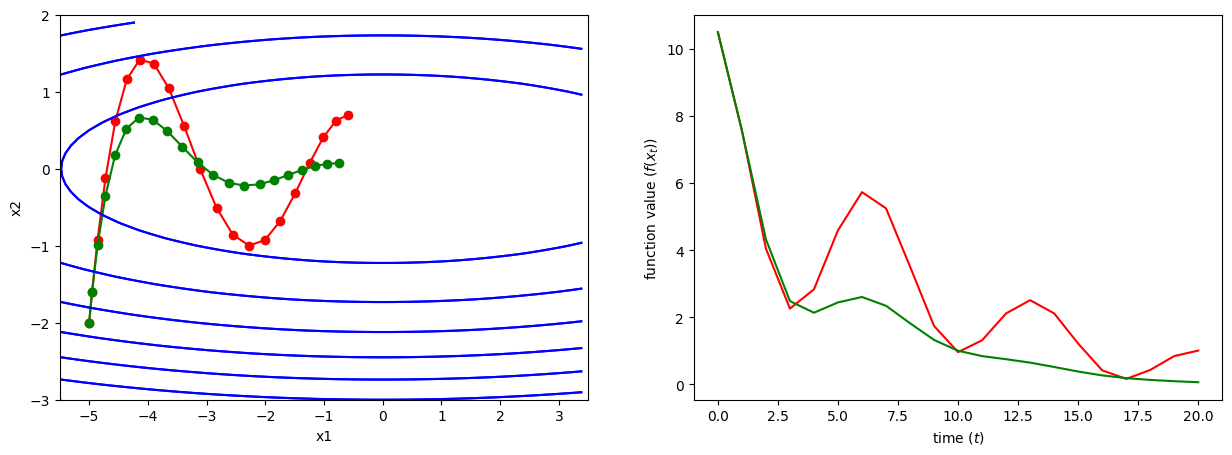

In [100]:
eta, gamma = 0.05, 0.9

def nesterov(x,v):
  v = gamma*v + eta*get_gradient(f, x-gamma*v)
  return x - v, v

show_trace_2d(f, optimize(momentum))
show_trace_2d(f, optimize(nesterov), color='green', is_new_plot=False)

epoch 20, x1 -0.230371, x2 -0.619899
epoch 20, x1 0.080840, x2 -0.000215


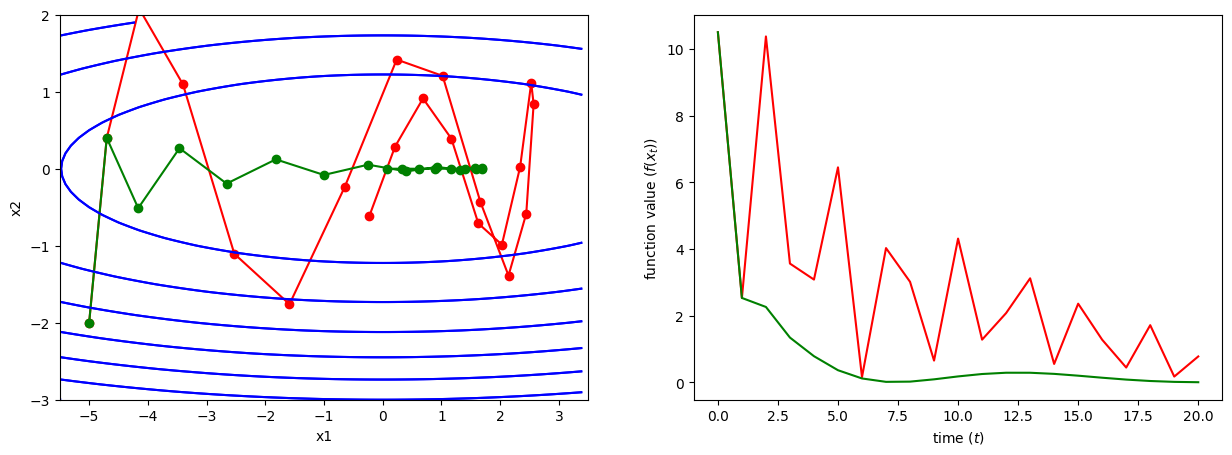

In [101]:
eta, gamma = 0.3, 0.9

show_trace_2d(f, optimize(momentum))
show_trace_2d(f, optimize(nesterov), color='green', is_new_plot=False)

## Adagrad

Same for `adagrad(x, s)` with $\varepsilon = 10^{-6}$, and test it with `eta = 0.4` and `eta = 1.5`.

epoch 20, x1 -2.382563, x2 -0.158591
epoch 20, x1 -0.042448, x2 -0.000000


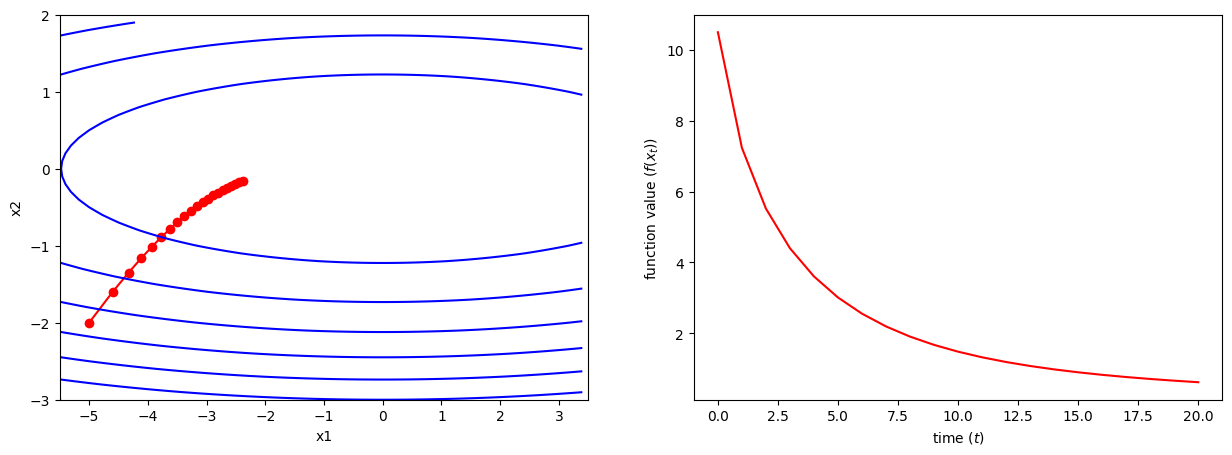

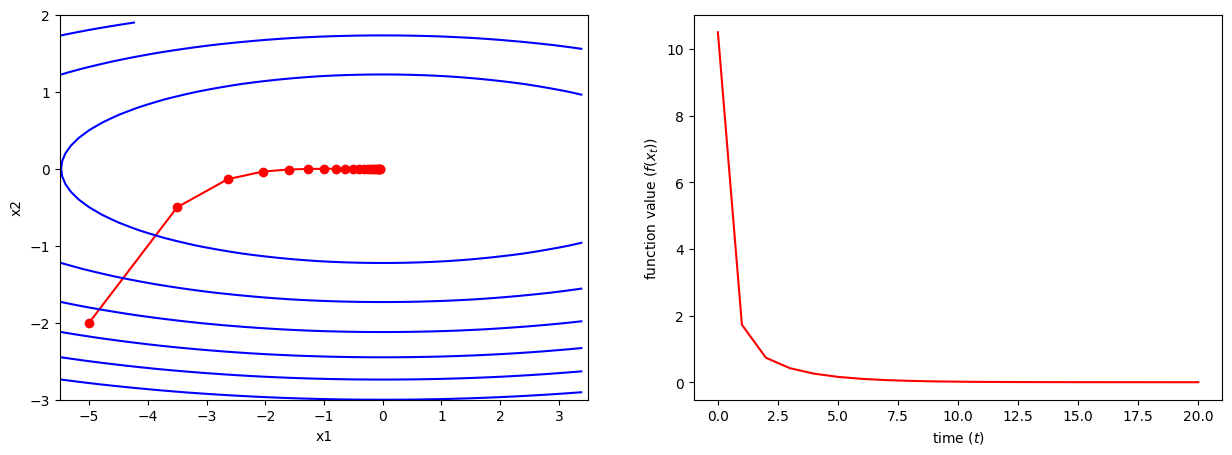

In [102]:
eps = 1e-6

def adagrad(x, s):
  s = s + get_gradient(f, x)**2
  return x - eta*get_gradient(f, x)/torch.sqrt(s+eps), s

eta = 0.4
show_trace_2d(f, optimize(adagrad))
eta = 1.5
show_trace_2d(f, optimize(adagrad))

## RMSProp

Same for `rmsprop(x, s)`, and test it with `eta, gamma = 0.4, 0.9`.

epoch 20, x1 -0.010599, x2 0.000000


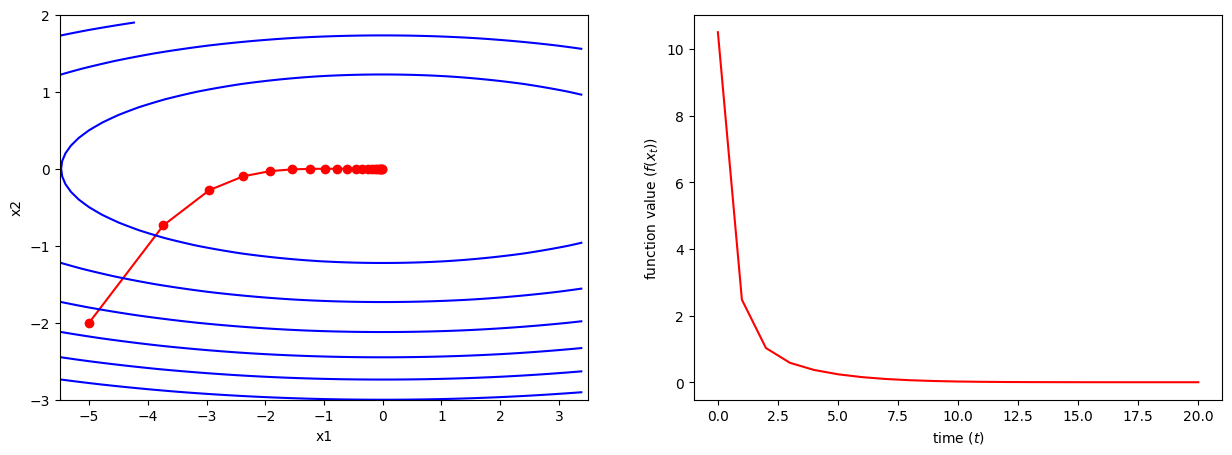

In [103]:
eps, eta, gamma = 1e-6, 0.4, 0.9

def rmsprop(x,s):
  s= gamma*s + (1-gamma)*get_gradient(f,x)**2
  return x - eta*get_gradient(f,x)/torch.sqrt(s+eps),s

show_trace_2d(f, optimize(rmsprop))

## Adam

Same for `adam(x, s)`, where the memory state will be a tuple `m, v, t = s` where `m` and `v` are the internal states, while `t` is the current iteration. Test it with `beta1, beta2, eta = 0.9, 0.99, 0.8`, and remember to initialize the internal state in the function `show_trace_2d`, here to `init_s=(0, 0, 0)`.

epoch 20, x1 0.414217, x2 0.086138


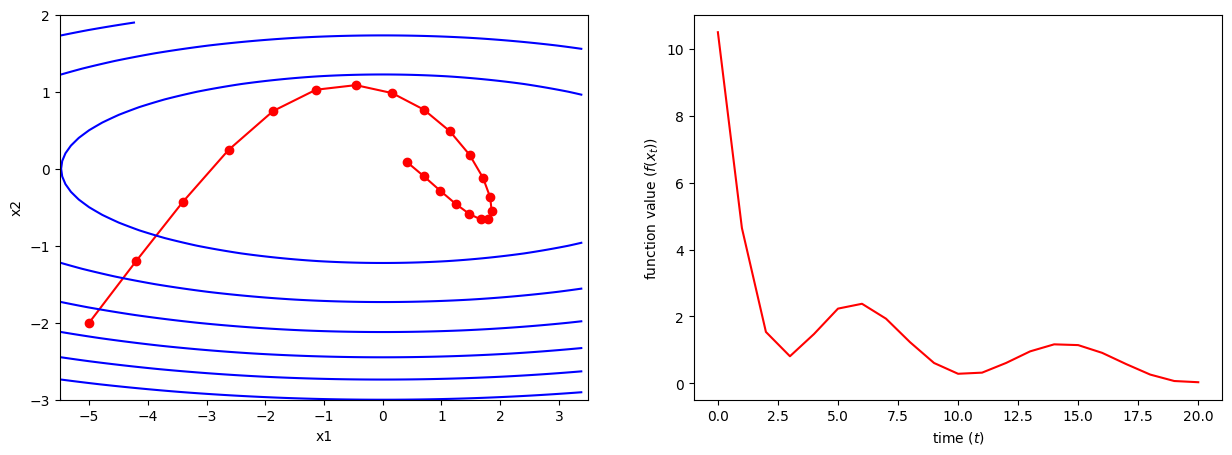

In [104]:
eps, beta1, beta2, eta = 1e-6, 0.9, 0.99, 0.8

def adam(x,s):
  m,v,t = s
  m = beta1*m + (1-beta1)*get_gradient(f,x)
  v = beta2*v + (1-beta2)*get_gradient(f,x)**2
  m_n, v_n = m/(1-beta1**(t+1)), v/(1-beta2**(t+1))
  return x - eta*m_n/(torch.sqrt(v_n) + eps),(m,v,t+1)

show_trace_2d(f, optimize(adam, init_s=(0,0,0)))

epoch 20, x1 1.029151, x2 -0.228458


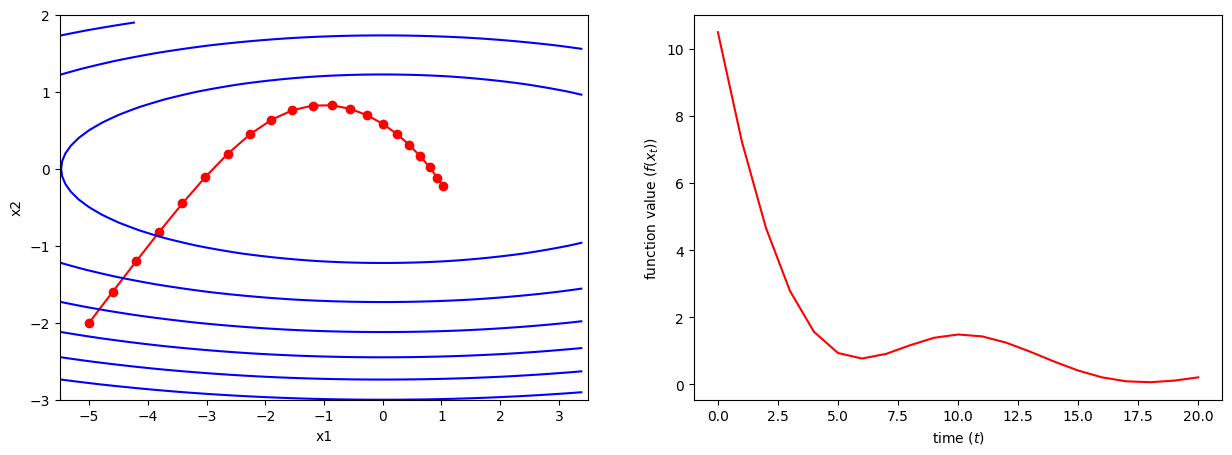

In [105]:
eta, beta1 = 0.4, 0.9
show_trace_2d(f, optimize(adam, init_s=(0, 0, 0)))

## AMSGrad

Same for `amsgrad(x, s)`, where the memory state will be a tuple `m, v, v_bar = s` (see slides for the meaning of each value). Compare Adam and AMSGrad with `beta1, beta2, eta = 0.9, 0.99, 1`.

epoch 20, x1 -0.977985, x2 -0.470241


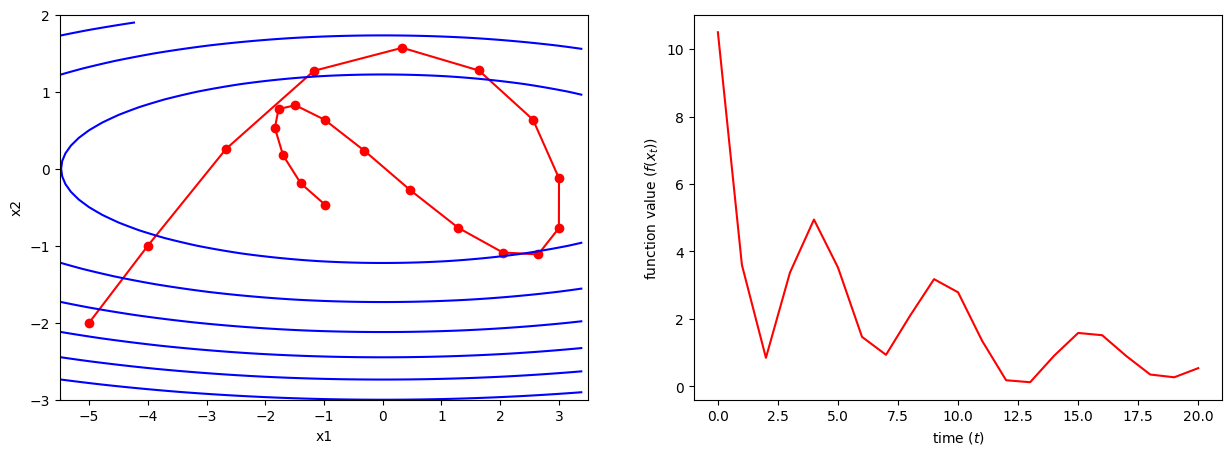

In [106]:
eps, beta1, beta2, eta = 1e-6, 0.9, 0.99, 1

def amsgrad(x,s):
  m,v,v_n = s
  m = beta1*m + (1-beta1)*get_gradient(f,x)
  v = beta2*v + (1-beta2)*get_gradient(f,x)**2
  v_n = torch.maximum(v_n, v)
  return x - eta*m/(torch.sqrt(v_n) + eps),(m,v,v_n,)

show_trace_2d(f, optimize(amsgrad, init_s=(0,0,torch.tensor([0,0]))))

epoch 20, x1 -0.977985, x2 -0.470241
epoch 20, x1 -0.571139, x2 0.487553


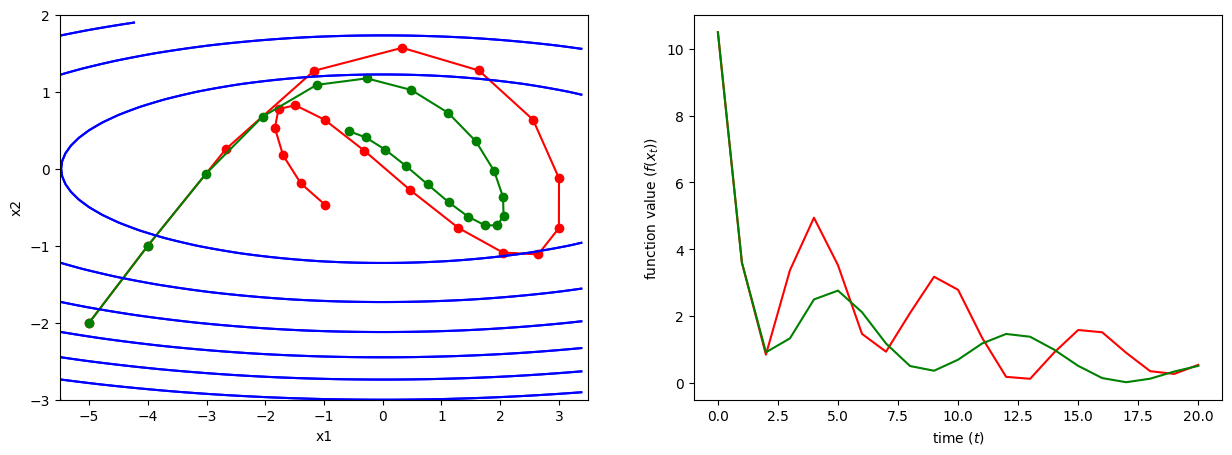

In [107]:
eta = 1
show_trace_2d(f, optimize(amsgrad, init_s=(0, 0, torch.Tensor([0, 0]))))
show_trace_2d(f, optimize(adam, init_s=(0, 0, 0)), color ='green', is_new_plot=False)

# Stochastic optimization and schedulers

We will now see what happens when the gradient is noisy.

First, write a function `sgd(x, s)` that performs one step of stochastic gradient descent, by adding a noise of standard deviation $0.8$ to the gradient at each iteration using `get_gradient(f, x, noise_std=0.8)`. Compare the effect of different different step-sizes $\eta\in\{0.4,0.2,0.05\}$ on the convergence.

epoch 200, x1 0.439433, x2 0.083986
epoch 200, x1 0.549638, x2 -0.073596
epoch 200, x1 -0.540616, x2 0.052059


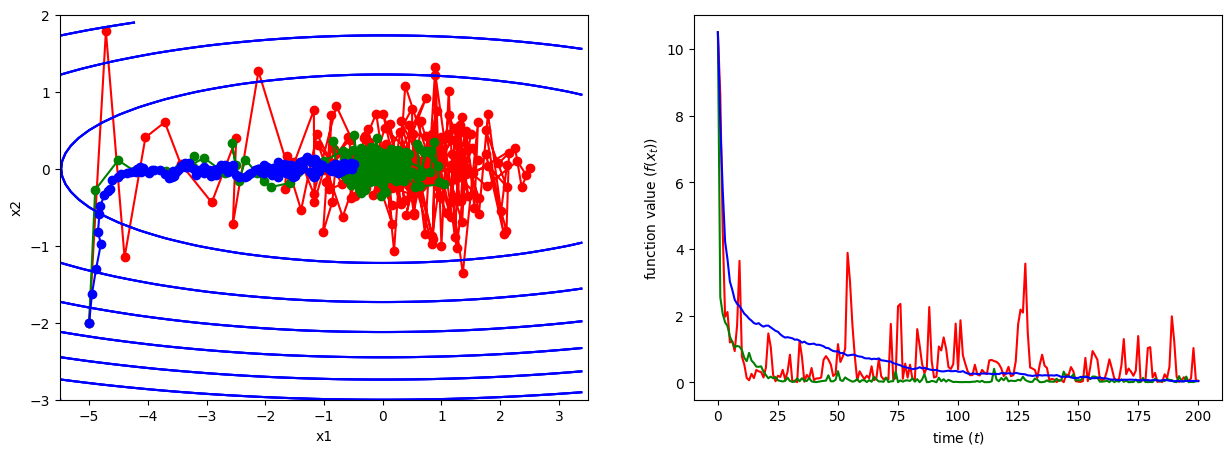

In [108]:
def sgd(x,s):
  return x-eta*get_gradient(f,x,noise_std= 0.8),s

eta = 0.4
show_trace_2d(f, optimize(sgd, num_iter=200))
eta = 0.2
show_trace_2d(f, optimize(sgd, num_iter=200), color='green', is_new_plot=False)
eta = 0.05
show_trace_2d(f, optimize(sgd, num_iter=200), color='blue', is_new_plot=False)

A high learning rate is faster, but a small learning rate leads to better final performance.
Propose a modification of sgd that use behavior this to its advantage in an update rule named `sgd_with_scheduler`. Compare its behavior with standard sgd in the previous setting.

In [109]:
def sgd_with_scheduler(x,t):
  return x- (eta/(1+t)**0.5)*get_gradient(f,x,noise_std=0.8), t+1



epoch 200, x1 -0.306447, x2 0.395156
epoch 200, x1 -0.495521, x2 0.001066
epoch 200, x1 -0.984293, x2 0.032687
epoch 200, x1 -0.873050, x2 -0.000062


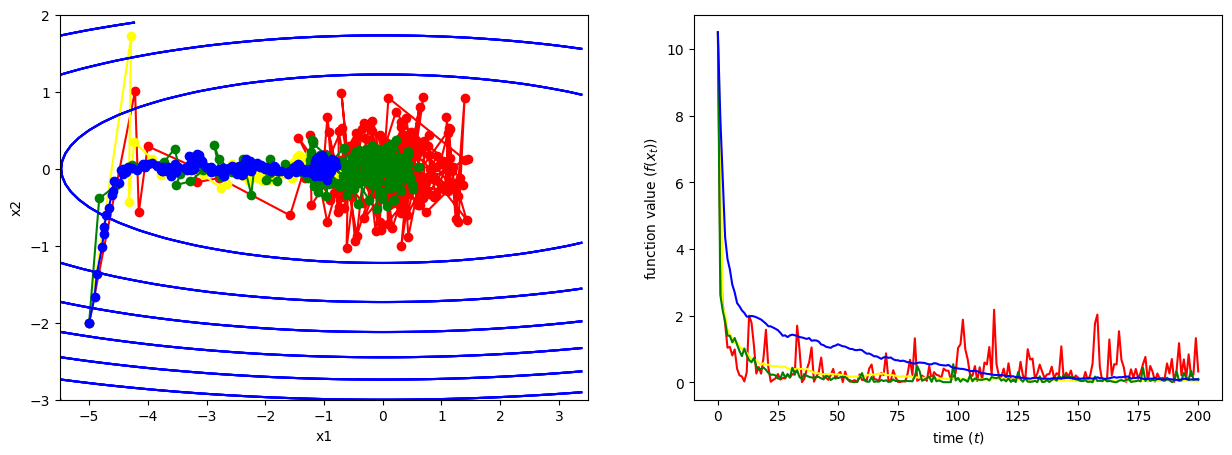

In [110]:
eta = 0.4
show_trace_2d(f, optimize(sgd, num_iter=200))
show_trace_2d(f, optimize(sgd_with_scheduler, num_iter=200), color='yellow', is_new_plot=False)
eta = 0.2
show_trace_2d(f, optimize(sgd, num_iter=200), color='green', is_new_plot=False)
eta = 0.05
show_trace_2d(f, optimize(sgd, num_iter=200), color='blue', is_new_plot=False)


We are now going to test sgd on a more realistic example: linear classification of a toy dataset. First, we generate a dataset with 2 classes, each being a distributed according to a Gaussian distribution.

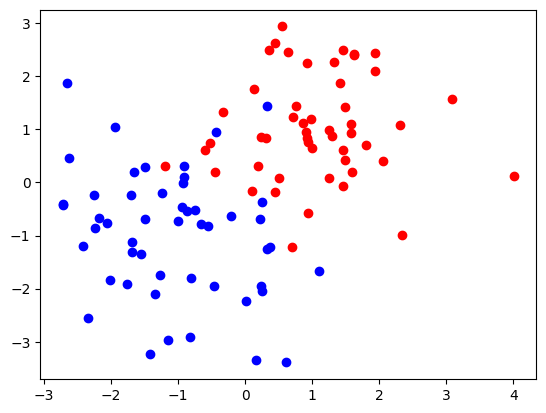

In [111]:
# Generating a dataset of two Gaussian classes and 100 samples
N = 100
v = torch.Tensor([1, 1]).unsqueeze(0)
Y = 2 * torch.randint(low=0, high=2, size=(N, 1), dtype=torch.float) - 1
X = 1 * torch.randn(N, 2) + Y @ v
plt.plot(X[Y.flatten() > 0,0], X[Y.flatten() > 0,1], 'o', color='red')
plt.plot(X[Y.flatten() < 0,0], X[Y.flatten() < 0,1], 'o', color='blue')

Now, write `mse_linear(theta)` that returns the MSE loss over the toy dataset for a simple linear model $y = \theta X$, as well as `mse_linear_mb(theta)` that returns the MSE loss over a random mini-batch of size `mini_batch_size`.

In [112]:
def mse_linear(theta):
    # WARNING: theta should be of size (2,1)
    theta = theta.unsqueeze(-1)
    return torch.mean((X@theta - Y)**2)



mini_batch_size = 1

def mse_linear_mb(theta):
    # WARNING: theta should be of size (2,1)
    theta = theta.unsqueeze(-1)
    index = torch.randperm(N)[:mini_batch_size]
    return torch.mean((X[index]@theta - Y[index])**2)
#
# YOUR CODE HERE
# WARNING: theta should be of size (2,1)
# HINT: use torch.randperm
#

Now, test a mini-batch version of Adam on this toy dataset, with `eta=0.1` and `mini_batch_size` in $\{1,5,10\}$. What do you see?

In [113]:
def adam_2(x,s):
  eps, beta1, beta2 = 1e-6, 0.9, 0.99
  m,v,t = s
  m = beta1*m + (1-beta1)*get_gradient(lambda x: mse_linear_mb(x),x)
  v = beta2*v + (1-beta2)*get_gradient(lambda x: mse_linear_mb(x),x)**2
  m_n, v_n = m/(1-beta1**(t+1)), v/(1-beta2**(t+1))
  return x - eta*m_n/(torch.sqrt(v_n) + eps),(m,v,t+1)

epoch 100, x1 -0.699517, x2 0.945550
epoch 100, x1 0.107794, x2 0.524652
epoch 100, x1 0.207265, x2 0.429169


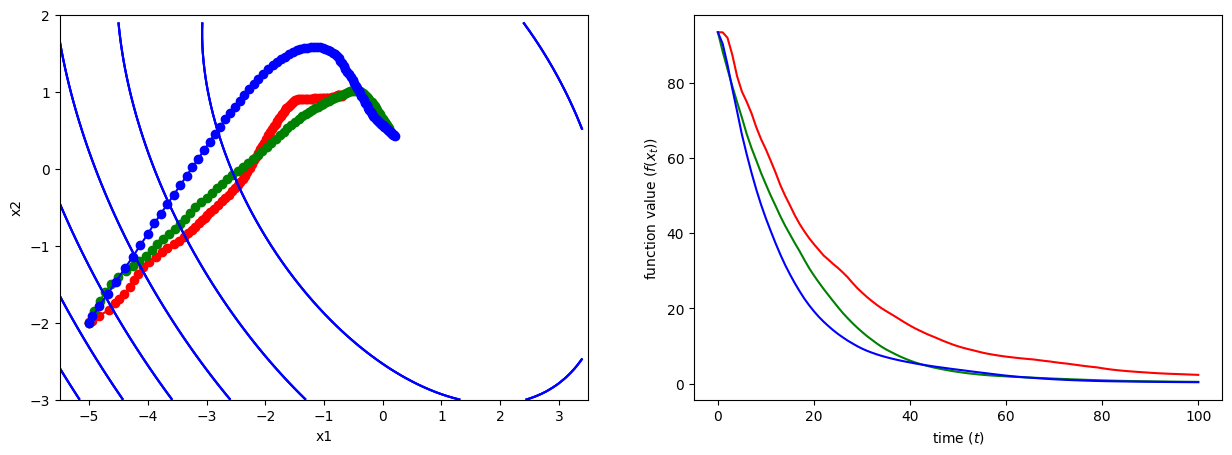

In [114]:
eta = 0.1
mini_batch_size = 1
show_trace_2d(mse_linear, optimize(adam_2, num_iter=100, init_s=(0, 0, 0)))
mini_batch_size = 5
show_trace_2d(mse_linear, optimize(adam_2, num_iter=100, init_s=(0, 0, 0)), color='green', is_new_plot=False)
mini_batch_size = 10
show_trace_2d(mse_linear, optimize(adam_2, num_iter=100, init_s=(0, 0, 0)), color='blue', is_new_plot=False)

# Pytorch optimizers and schedulers
Typical training loop, optimizers and schedulers in Pytorch

In [ ]:
# MINIMAL (AND INCOMPLETE) EXAMPLE
for epoch in range(20):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

In [ ]:
# MORE DETAILED AND COMPLETE EXAMPLE

### PARAMETERS
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 100

### DATA, MODEL, LOSS, OPTIMIZER AND SCHEDULER
dataloader = ... # YOUR DATA
model = ... # YOUR MODEL
criterion = ... # YOUR LOSS FUNCTION
optimizer = ... # YOUR OPTIMIZER
scheduler = ... # YOUR SCHEDULER

### TRAINING LOOP
# Prepares the model for training (needed for some models)
model.train()

for epoch in range(num_epochs):
    # One training epoch over the whole dataset
    for inputs, targets in dataloader:
        # One mini-batch, put on the desired devide (cpu or gpu)
        inputs, targets = inputs.to(device), targets.to(device)

        # Reinitialize the gradients before any computation
        optimizer.zero_grad()

        # Computation of the model's output and loss on the mini-batch
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Computation of the gradient on the mini-batch
        loss.backward()

        # One iteration of the optimizer and update of the step-size
        optimizer.step()

        # Then we can compute statistics and store loss values
        ...

    # Update of the step-size
    scheduler.step()
    print('Loss: {:.4f} Acc: {:.4f}'.format(..., ...))

In [ ]:
# Typical optimizers and schedulers
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: 1/t**0.5)

In [ ]:
# If you want to implement your own optimizer
class SuperDuperOptimizer(optim.Optimizer):
    def __init__(self, params, lr):
        defaults = dict(lr=lr)
        super(SuperDuperOptimizer, self).__init__(params, defaults)

    def step():
        ...